In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, norm
import scipy.integrate as integrate
import seaborn as sns

**Ejercicio 1.** Supongamos la función:
$$
f(x)=\sin(2\pi x)^5−2\cos\left(3\cos\left(\frac{x}{\pi}\right)^2\right)^3
$$
y el intervalo $(a,b)=(0,10)$. Estimar el área delimitada por la función $f(x)$  en el intervalo $(a,b)$. Evaluar (gráficamente) la precisión (incertidumbre) de la estimación.

In [2]:
f = lambda x: np.sin(2*np.pi*x)**5 -2*np.cos(3*np.cos(x/np.pi)**2)**3 + 4

In [3]:
def print_function(f, x):
    plt.plot(x,f(x))
    plt.show()

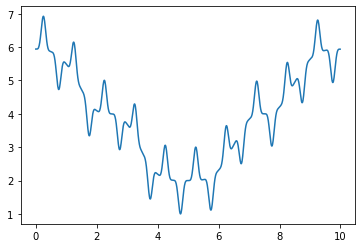

In [4]:
print_function(f, np.arange(0,10,0.01))

In [5]:
def integrate_MC(f, xlims, ylims, samples = 50000, plot = False, verbose = False):
    x = uniform.rvs(xlims[0], xlims[1] - xlims[0], samples)
    y = uniform.rvs(ylims[0], ylims[1]-ylims[0], samples)
    points = np.array([1 if y[i] <= f(x[i]) else 0 for i in range(samples)])
    if plot:
        plt.scatter(x[points == 1], y[points == 1], s=1, color="red")
        plt.scatter(x[points == 0], y[points == 0], s=1, color="blue")

    const = (xlims[1] - xlims[0])*(ylims[1]- ylims[0])
    mean = np.sum(points)/samples
    area = const*mean
    if verbose:
        print("Resultado: ", integrate.quad(f, *xlims)[0], 
              "\nEstimación: ", area)
    return area

Resultado:  39.383414317445194 
Estimación:  39.318999999999996


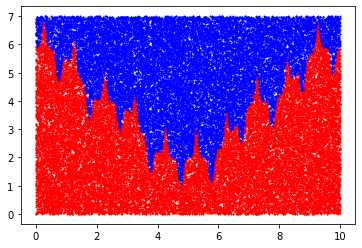

In [6]:
res = integrate_MC(f, (0,10), (0,7), plot=True, verbose = True)

In [7]:
a = np.array([integrate_MC(f, (0,10), (0, 7), 1000) for _ in range(1000)])

In [8]:
b = np.array([integrate_MC(f, (0,10), (0, 7), 10000) for _ in range(1000)])

In [9]:
def plot_kde_and_ecdf(x1, x2, value):
    _, axes = plt.subplots(1, 2, figsize=(15,5))
    sns.kdeplot(x1, ax = axes[0], fill = True)
    sns.kdeplot(x2, ax = axes[0], fill = True)
    ylims = axes[0].get_ylim()
    axes[0].vlines(value, *ylims, color = "red")
    axes[0].set_ylim(*ylims)
    sns.ecdfplot(x1, ax = axes[1])
    sns.ecdfplot(x2, ax = axes[1])

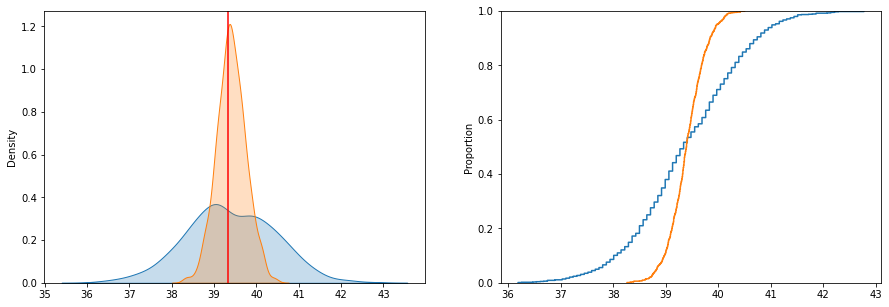

In [10]:
plot_kde_and_ecdf(a,b, res)

In [11]:
f = lambda x: (1-x**2)**(0.5)

In [12]:
def integrate_means(f, xlim, samples = 1000):
    x = uniform.rvs(0, 1, samples)
    return np.sum(f(x))/samples

In [17]:
res = integrate_means(f, 1,10000)
print("Valor obtenido: ", res, "\nValor real: ", np.pi/4)

Valor obtenido:  0.7813720686906918 
Valor real:  0.7853981633974483


In [18]:
a = np.array([integrate_MC(f, (0,1), (0, 1), 1000) for _ in range(1000)])
b = np.array([integrate_means(f, 1, 10000) for _ in range(1000)])

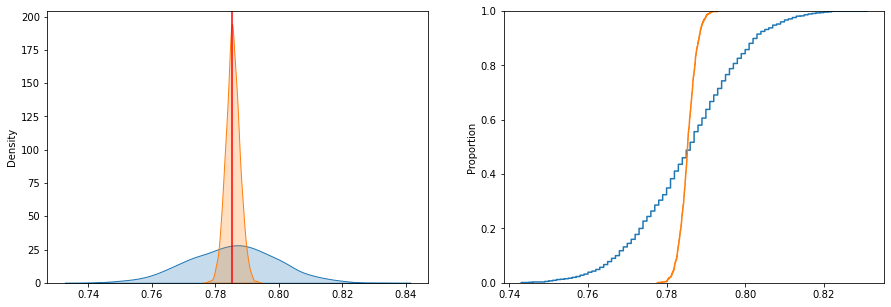

In [19]:
plot_kde_and_ecdf(a,b, np.pi/4)

In [102]:
alpha = 0.005

In [103]:
z_alpha = norm.ppf(1-(alpha/2))
print(z_alpha)

2.807033768343811


In [104]:
x = uniform.rvs(0, 1, 50000)
y = f(x)
size = np.arange(start = 1, stop = 50000+1, step = 1)

media = np.cumsum(y) / size

s2 = (y - media) * (y - media)
s2[0] = 0
s2[1:] = np.cumsum(s2)[1:]/size[0:-1]

sigma2 = s2/size
ic = z_alpha*np.sqrt(sigma2)/np.sqrt(size)
print(ic)

[0.00000000e+00 3.05032268e-01 1.75798684e-01 ... 1.25855176e-05
 1.25852460e-05 1.25849269e-05]


In [105]:
print(y)

[0.89455235 0.45988389 0.44792683 ... 0.95858626 0.98968071 0.93677818]


In [106]:
print(media)

[0.89455235 0.67721812 0.60078769 ... 0.78395989 0.783964   0.78396706]


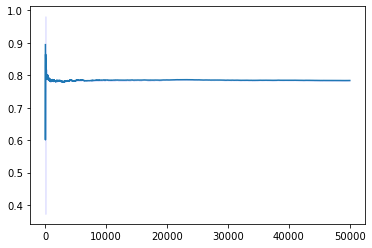

In [109]:
fig, ax = plt.subplots()

ax.plot(media)
ax.fill_between(size, media-ic, media+ic, color='b', alpha=.1)